Bazham Khanatayev \
Data 512 Part 1 - Common Analysis \
11.1.2023

This notebook covers the entire task for Part 1 Common Analysis. I start with reading all of the Fire Data and only grabbing the relevant subset that I need for my city. Then, I create the smoke estimates and get some data from the EPA AQI API. After that, I train a model to predict smoke for the upcoming years and also produce the necessary visuals. Lets start with reading the data.

# Reading the file and grabbing subset

In this first section, we will use the code provided by the professor in order to understand how the json is structured.

## Reading the Data

In [1]:
#
#    IMPORTS
# 

#    Import some standard python modules
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.
#    
from wildfire.Reader import Reader as WFReader
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson

In [2]:
#
#    CONSTANTS
#

#
#    The 'Wildfire_short_sample.json' is an extraction from the full 'USGS_Wildland_Fire_Combined_Dataset.json'
#    dataset extracting some of the major wildfires in California. These were extracted by name, with possible names
#    coming from https://en.wikipedia.org/wiki/List_of_California_wildfires
#
#    The sample file includes data for 13 fires, mostly oriented around the uniqueness of the name. Naming conventions
#    for wildfires is really adhoc, which makes finding any named fire in the dataset a disambiguation mess. The point
#    of the sample is to provide something small to test with before committing to processing the much larger full dataset.
#
EXTRACT_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"
#
#    The user module 'wildfire' contains a Reader object and the sample data. This bit of code finds
#    where that is located on your machine and constructs a path so that the sample data can be loaded.
#    This assumes you have set a PYTHONPATH environment variable to point to the location on your machine
#    where you store python user modules.
#
#    NOTE: if you use Anaconda for virtual python environments, Anaconda will adhere to the PYTHONPATH conventions
#    for user modules.
#
MODULENAME = "wildfire"
MODULEPATH = ""
try:
    ppath = os.environ.get('PYTHONPATH')
    if not ppath: raise
    MODULEPATH = os.path.join(ppath,MODULENAME)
except:
    # Likely here because a PYTHONPATH was not set, show a warning message
    print("Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.")
    print("You may have to modify the sample code in this notebook to get the described results.")
    MODULEPATH = ""

if MODULEPATH:
    SAMPLE_DATA_FILENAME = os.path.join(MODULEPATH,EXTRACT_FILENAME)
else:
    SAMPLE_DATA_FILENAME = EXTRACT_FILENAME
#
# print out where we think we're going to find the sample data
print(f"{SAMPLE_DATA_FILENAME=}")

#
#    A dictionary of some city locations from the US west coast states.
#
CITY_LOCATIONS = {
    'anchorage' :     {'city'   : 'Anchorage',
                       'latlon' : [61.2176, -149.8997] },
    'ocean_shores' :  {'city'   : 'Ocean Shores',    
                       'latlon' : [47.0074, -124.1614] },
    'seaside' :       {'city'   : 'Seaside',
                       'latlon' : [45.9932, -123.9226] }, 
    'bend' :          {'city'   : 'Bend',
                       'latlon' : [44.0582, -121.3153] }, 
    'medford' :       {'city'   : 'Medford',
                       'latlon' : [42.3265, -122.8756] }, 
    'crescent_city' : {'city'   : 'Crescent City',
                       'latlon' : [41.7558, -124.2026] }, 
    'tomales' :       {'city'   : 'Tomales',
                       'latlon' : [38.2411, -122.9033] }, 
    'barstow' :       {'city'   : 'Barstow',
                       'latlon' : [34.8958, -117.0173] }, 
    'redding' :       {'city'   : 'Redding',
                       'latlon' : [40.5865, -122.3916] }, 
    'encinitas' :     {'city'   : 'Encinitas',
                       'latlon' : [33.0370, -117.2920] } 
}



Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.
You may have to modify the sample code in this notebook to get the described results.
SAMPLE_DATA_FILENAME='USGS_Wildland_Fire_Combined_Dataset.json'


In [3]:
SAMPLE_DATA_FILENAME='Wildfire_short_sample.json'

In [4]:
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}'")
geojson_file = open(SAMPLE_DATA_FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{SAMPLE_DATA_FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()
#
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()
#
#    For all GeoJSON type things, the most important part of the file are the 'features'. 
#    In the case of the wildfire dataset, each feature is a polygon (ring) of points that define the bounary of a fire
#
count = 0
for feature in gj_data['features']:
    count += 1
    #print(json.dumps(feature,indent=4))
    time.sleep(0.5)   # this slows the output to fix output rate limits for Jupyter

print(f"Found {count} features in the variable 'gj_data' ")

Attempting to open 'Wildfire_short_sample.json'
Using GeoJSON module to load sample file 'Wildfire_short_sample.json'
The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']

Found 13 features in the variable 'gj_data' 


In [5]:
#    Get the first item in the list of features
#
SLOT = 0
gj_feature = gj_data['features'][SLOT]
#
#    Print everyting in this dictionary (i.e., gj_feature) - it's long
#
print(f"The wildfire feature from slot '{SLOT}' of the loaded gj_data['features']")
print(json.dumps(gj_feature, indent=4))

The wildfire feature from slot '0' of the loaded gj_data['features']
{
    "attributes": {
        "OBJECTID": 4956,
        "USGS_Assigned_ID": 4956,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1932,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1), 3 (3)",
        "GIS_Acres": 219999.23754748085,
        "GIS_Hectares": 89030.53273921262,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_National_USFS_Final_Fire_Perimeter (1), Comb_National_WFDSS_Interagency_Fire_Perimeter_History (1), Comb_State_California_Wildfire_Polygons (1)",
        "Listed_Fire_Types": "Wildfire (3), Likely Wildfire (1)",
        "Listed_Fire_Names": "MATILIJA (4)",
        "Listed_Fire_Codes": "No code provided (4)",
        "Listed_Fire_IDs": "0 (3)",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Wildfire Discovery Date(s): 1932-09-07 (2) | Listed Other Fire Date(s): 1899-12-30 - REVDATE field (1), 

In [6]:
#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
# 
# Get the geometry for the feature we pulled from the feature_list
gj_geometry = gj_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
gj_bigest_ring = gj_geometry['rings'][0]

print(f"The largest ring of gj_feature['features'][{SLOT}]['rings'] consists of {len(gj_bigest_ring)} points.")

The largest ring of gj_feature['features'][0]['rings'] consists of 1132 points.


In [7]:
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(SAMPLE_DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(gj_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))

Attempting to open 'Wildfire_short_sample.json' with wildfire.Reader() object

The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_Cau

In [8]:
#    This sample code will load the whole sample file, or a small amount of the complete dataset.
#
MAX_FEATURE_LOAD = 100
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 100) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    if feature_count >= MAX_FEATURE_LOAD:
        break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Loaded a total of 13 features
Variable 'feature_list' contains 13 features


In [9]:
#
#    The 'feature_list' variable was created when we read the sample file in a code cell above
#    Now, we're just going to look at one single feature - see what is in there
#
SLOT = 0
wf_feature = feature_list[SLOT]

# Print everyting in this dictionary (i.e., wf_feature) - it's long
print(f"The wildfire feature from slot '{SLOT}' of the loaded 'feature_list'")
print(json.dumps(wf_feature, indent=4))

The wildfire feature from slot '0' of the loaded 'feature_list'
{
    "attributes": {
        "OBJECTID": 4956,
        "USGS_Assigned_ID": 4956,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1932,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1), 3 (3)",
        "GIS_Acres": 219999.23754748085,
        "GIS_Hectares": 89030.53273921262,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_National_USFS_Final_Fire_Perimeter (1), Comb_National_WFDSS_Interagency_Fire_Perimeter_History (1), Comb_State_California_Wildfire_Polygons (1)",
        "Listed_Fire_Types": "Wildfire (3), Likely Wildfire (1)",
        "Listed_Fire_Names": "MATILIJA (4)",
        "Listed_Fire_Codes": "No code provided (4)",
        "Listed_Fire_IDs": "0 (3)",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Wildfire Discovery Date(s): 1932-09-07 (2) | Listed Other Fire Date(s): 1899-12-30 - REVDATE field (1), 1932-

In [10]:
#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
# 
# Get the geometry for the feature we pulled from the feature_list
wf_geometry = wf_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
wf_bigest_ring = wf_geometry['rings'][0]

print(f"The largest ring of wf_feature['features'][{SLOT}]['rings'] consists of {len(wf_bigest_ring)} points.")

The largest ring of wf_feature['features'][0]['rings'] consists of 1132 points.


In the following cell, we set our city location to Logan,Utah. This is my assigned city.

In [11]:
CITY_LOCATIONS = {
    'logan' :     {'city'   : 'Logan',
                       'latlon' : [41.7370, 111.8338] },
   
}

In [12]:
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [13]:
#   Convert one ring from the default to EPSG
#
#   There are two options here - depending upon whether you loaded data useing GeoJSON or the wildfire.Reader
#
#ring_in_epsg4326 = convert_ring_to_epsg4326(gj_bigest_ring)
#
ring_in_epsg4326 = convert_ring_to_epsg4326(wf_bigest_ring)
#
print(f"Ring consists of {len(ring_in_epsg4326)} points.")
#
#    If you want to print them out you can see what they look like converted.
#print(ring_in_epsg4326)
#for point in ring_in_epsg4326:
#    print(f"{point[0]},{point[1]}")

Ring consists of 1132 points.


The following function is given to us.

In [14]:
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

In [15]:
#    Get a city from our CITY_LOCATIONS constant as our starting position
place = CITY_LOCATIONS["logan"]
#place = CITY_LOCATIONS["medford"]
#place = CITY_LOCATIONS["encinitas"]


for wf_feature in feature_list:
    #print(f"{place['city']}")
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    ring_data = wf_feature['geometry']['rings'][0]
    #
    #     Compute using the shortest distance to any point on the perimeter
    #
    distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    print(f"The closest distance of fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was {distance[0]:1.2f} miles to {place['city']}")
    print(f"\tThe cloest perimiter point lat,lon {distance[1][0]},{distance[1][1]}")
    #
    #     Compute using the average distance to all points on the perimeter
    #
    #distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    #print(f"Fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was an average {distance:1.2f} miles to {place['city']}")
    #ring = convert_ring_to_epsg4326(ring_data)
    #perimeter_start = ring[0]
    #print(f"\tOne perimiter point lat,lon {perimiter_start[0]},{perimeter_start[1]}")
    

The closest distance of fire 'MATILIJA (4)' (219999.24 acres) from 1932 was 6254.56 miles to Logan
	The cloest perimiter point lat,lon 34.613698315372666,-119.4959439094763
The closest distance of fire 'CEDAR (6)' (271157.85 acres) from 2003 was 6444.56 miles to Logan
	The cloest perimiter point lat,lon 32.786728032123094,-116.86327594379371
The closest distance of fire 'CEDAR MOUNTAIN (4)' (29.36 acres) from 2003 was 5819.27 miles to Logan
	The cloest perimiter point lat,lon 43.30066858913262,-117.7360687998917
The closest distance of fire 'CEDAR 3 (5)' (1.15 acres) from 2003 was 5872.11 miles to Logan
	The cloest perimiter point lat,lon 39.59130006056183,-122.74335608128276
The closest distance of fire 'ZACA (7)' (240358.65 acres) from 2007 was 6234.26 miles to Logan
	The cloest perimiter point lat,lon 34.771388092196716,-119.84131936521004
The closest distance of fire 'RANCH (4)' (394.07 acres) from 2007 was 6249.42 miles to Logan
	The cloest perimiter point lat,lon 34.5441725559451

We were previously working with a sample of the entire file in order to assist with exploration. Now that we have a good idea about the data structure and pitfalls, we can start grabbing what we need.

In [16]:
import pandas as pd
import json

# Load JSON data from the file
with open('USGS_Wildland_Fire_Combined_Dataset.json', 'r') as file:
    wildfire_data = json.load(file)

# Convert JSON data to DataFrame
df_wildfires = pd.json_normalize(wildfire_data['features'], sep='_')

# Filter for the last 60 years (1963-2023)
df_years = df_wildfires[(df_wildfires['attributes_Fire_Year'] >= 1963) & (df_wildfires['attributes_Fire_Year'] <= 2023)]


In [17]:
df_years.columns

Index(['attributes_OBJECTID', 'attributes_USGS_Assigned_ID',
       'attributes_Assigned_Fire_Type', 'attributes_Fire_Year',
       'attributes_Fire_Polygon_Tier', 'attributes_Fire_Attribute_Tiers',
       'attributes_GIS_Acres', 'attributes_GIS_Hectares',
       'attributes_Source_Datasets', 'attributes_Listed_Fire_Types',
       'attributes_Listed_Fire_Names', 'attributes_Listed_Fire_Codes',
       'attributes_Listed_Fire_IDs', 'attributes_Listed_Fire_IRWIN_IDs',
       'attributes_Listed_Fire_Dates', 'attributes_Listed_Fire_Causes',
       'attributes_Listed_Fire_Cause_Class',
       'attributes_Listed_Rx_Reported_Acres',
       'attributes_Listed_Map_Digitize_Methods', 'attributes_Listed_Notes',
       'attributes_Processing_Notes', 'attributes_Wildfire_Notice',
       'attributes_Prescribed_Burn_Notice', 'attributes_Wildfire_and_Rx_Flag',
       'attributes_Overlap_Within_1_or_2_Flag', 'attributes_Circleness_Scale',
       'attributes_Circle_Flag', 'attributes_Exclude_From_Summary

In [18]:
df_years["attributes_Listed_Fire_Dates"]

14298     Listed Wildfire Discovery Date(s): 1963-08-06 ...
14299     Listed Wildfire Discovery Date(s): 1963-07-28 ...
14300     Listed Wildfire Discovery Date(s): 1963-08-06 ...
14301     Listed Wildfire Discovery Date(s): 1963-08-06 ...
14302     Listed Wildfire Discovery Date(s): 1963-08-06 ...
                                ...                        
135056    Listed Prescribed Fire End Date(s): 2020-01-01...
135057    Listed Prescribed Fire End Date(s): 2020-05-16...
135058    Listed Prescribed Fire End Date(s): 2020-05-16...
135059    Listed Prescribed Fire Start Date(s): 2020-07-...
135060    Listed Prescribed Fire End Date(s): 2020-01-01...
Name: attributes_Listed_Fire_Dates, Length: 117578, dtype: object

In [20]:
df_years.shape

(117578, 32)

The following function uses the distance calculation formula provided by the professor and also a small modification in order to skip over fires that do not have a ring defined.

In [27]:
# Function to safely apply the distance calculation
def safe_distance_calculation(rings, place):
    # Check if rings is not None and is a list
    if rings and isinstance(rings, list) and len(rings) > 0:
        # Check if the first element of rings is also a list (to catch nested lists)
        if isinstance(rings[0], list):
            return shortest_distance_from_place_to_fire_perimeter(place['latlon'], rings[0])[0]
    # If the checks fail, return infinity to signify no valid distance was calculated
    return float('inf')

# Apply the safe distance calculation function to the 'geometry_rings' column
df_years['shortest_distance_to_logan'] = df_years['geometry_rings'].apply(
    lambda rings: safe_distance_calculation(rings, logan_location)
)

<ipython-input-27-bdc7becb12ab>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_years['shortest_distance_to_logan'] = df_years['geometry_rings'].apply(


In [28]:
df_years.columns

Index(['attributes_OBJECTID', 'attributes_USGS_Assigned_ID',
       'attributes_Assigned_Fire_Type', 'attributes_Fire_Year',
       'attributes_Fire_Polygon_Tier', 'attributes_Fire_Attribute_Tiers',
       'attributes_GIS_Acres', 'attributes_GIS_Hectares',
       'attributes_Source_Datasets', 'attributes_Listed_Fire_Types',
       'attributes_Listed_Fire_Names', 'attributes_Listed_Fire_Codes',
       'attributes_Listed_Fire_IDs', 'attributes_Listed_Fire_IRWIN_IDs',
       'attributes_Listed_Fire_Dates', 'attributes_Listed_Fire_Causes',
       'attributes_Listed_Fire_Cause_Class',
       'attributes_Listed_Rx_Reported_Acres',
       'attributes_Listed_Map_Digitize_Methods', 'attributes_Listed_Notes',
       'attributes_Processing_Notes', 'attributes_Wildfire_Notice',
       'attributes_Prescribed_Burn_Notice', 'attributes_Wildfire_and_Rx_Flag',
       'attributes_Overlap_Within_1_or_2_Flag', 'attributes_Circleness_Scale',
       'attributes_Circle_Flag', 'attributes_Exclude_From_Summary

In [29]:
# Filter for fires within 1250 miles of Logan
df_years = df_years[df_years['shortest_distance_to_logan'] <= 1250]

In [33]:
df_years.head()

,attributes_OBJECTID,attributes_USGS_Assigned_ID,attributes_Assigned_Fire_Type,attributes_Fire_Year,attributes_Fire_Polygon_Tier,attributes_Fire_Attribute_Tiers,attributes_GIS_Acres,attributes_GIS_Hectares,attributes_Source_Datasets,attributes_Listed_Fire_Types,...,attributes_Wildfire_and_Rx_Flag,attributes_Overlap_Within_1_or_2_Flag,attributes_Circleness_Scale,attributes_Circle_Flag,attributes_Exclude_From_Summary_Rasters,attributes_Shape_Length,attributes_Shape_Area,geometry_rings,geometry_curveRings,shortest_distance_to_logan
14298,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,None,None,0.385355,NaN,No,73550.428118,1.658906e+08,"[[[-1538222.6155999992, 664547.1687000003], [-...",NaN,292.452481
14299,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,None,None,0.364815,NaN,No,59920.576713,1.042352e+08,"[[[-1561373.1005000006, 710862.5734999999], [-...",NaN,323.475050
14300,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,None,None,0.320927,NaN,No,84936.827810,1.842421e+08,"[[[-1516651.6959000006, 689701.9166000001], [-...",NaN,289.770987
14301,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,None,None,0.428936,NaN,No,35105.903602,4.206711e+07,"[[[-1495760.2166000009, 539132.1772000007], [-...",NaN,222.169331
14302,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,None,None,0.703178,NaN,No,26870.456126,4.040222e+07,"[[[-1520641.9629999995, 654341.4522999991], [-...",NaN,280.705597


In [119]:
# This is for storing our subset of data in case the kernal dies or we need to access it again.
# df_years.to_csv('df_logan_fires.csv', index=False)


In [34]:
df_years

,attributes_OBJECTID,attributes_USGS_Assigned_ID,attributes_Assigned_Fire_Type,attributes_Fire_Year,attributes_Fire_Polygon_Tier,attributes_Fire_Attribute_Tiers,attributes_GIS_Acres,attributes_GIS_Hectares,attributes_Source_Datasets,attributes_Listed_Fire_Types,...,attributes_Wildfire_and_Rx_Flag,attributes_Overlap_Within_1_or_2_Flag,attributes_Circleness_Scale,attributes_Circle_Flag,attributes_Exclude_From_Summary_Rasters,attributes_Shape_Length,attributes_Shape_Area,geometry_rings,geometry_curveRings,shortest_distance_to_logan
14298,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,None,None,0.385355,NaN,No,73550.428118,1.658906e+08,"[[[-1538222.6155999992, 664547.1687000003], [-...",NaN,292.452481
14299,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,None,None,0.364815,NaN,No,59920.576713,1.042352e+08,"[[[-1561373.1005000006, 710862.5734999999], [-...",NaN,323.475050
14300,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,None,None,0.320927,NaN,No,84936.827810,1.842421e+08,"[[[-1516651.6959000006, 689701.9166000001], [-...",NaN,289.770987
14301,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,None,None,0.428936,NaN,No,35105.903602,4.206711e+07,"[[[-1495760.2166000009, 539132.1772000007], [-...",NaN,222.169331
14302,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,None,None,0.703178,NaN,No,26870.456126,4.040222e+07,"[[[-1520641.9629999995, 654341.4522999991], [-...",NaN,280.705597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135056,135057,135057,Prescribed Fire,2020,8,8 (3),16.412148,6.641761,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (3),...,None,"Caution, this Prescribed Fire in 2020 overlaps...",0.177425,NaN,No,2168.900740,6.641761e+04,"[[[-2008802.4960999992, 729335.5622000005], [-...",NaN,578.802441
135057,135058,135058,Prescribed Fire,2020,8,8 (1),7.050837,2.853373,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,None,"Caution, this Prescribed Fire in 2020 overlaps...",0.374368,NaN,No,978.666221,2.853373e+04,"[[[-1648510.3187000006, 666410.7272999994], [-...",NaN,353.052861
135058,135059,135059,Prescribed Fire,2020,8,8 (4),9.342668,3.780843,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (4),...,None,"Caution, this Prescribed Fire in 2020 overlaps...",0.123888,NaN,No,1958.326660,3.780843e+04,"[[[-1649244.5655000005, 664993.7576000001], [-...",NaN,352.889014
135059,135060,135060,Prescribed Fire,2020,8,8 (1),0.996962,0.403456,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,None,None,0.993809,1.0,No,225.866452,4.034562e+03,"[[[-1017808.4253000002, 140344.1116000004], [-...",NaN,175.398687


The following function creates a simple smoke estimate based off of the size of the fire and its proximity to Logan, Utah. It is very similar to the function above but makes some modifications to avvoid using slices.

In [41]:
df_years = df_years.copy()

# Example function to calculate the smoke impact score based on the provided columns
def calculate_smoke_impact(size_acres, distance_miles):
    # Assuming the impact of smoke decreases with the square of the distance
    if distance_miles == 0:  # To handle division by zero if distance is very small
        return size_acres
    return size_acres / (distance_miles ** 2)

# Apply the function to each fire in the dataframe
df_years['smoke_impact'] = df_years.apply(
    lambda x: calculate_smoke_impact(x['attributes_GIS_Acres'], x['shortest_distance_to_logan']),
    axis=1
)

# Group by year and sum the smoke impact for a cumulative yearly score
df_smoke_impact_by_year = df_years.groupby('attributes_Fire_Year')['smoke_impact'].sum().reset_index()

# This will give you the cumulative impact score for each year.
# If you wish to have an amortized score over the fire season, 
# you would need to divide by the number of days in the fire season (184 days from May 1st to October 31st).
df_smoke_impact_by_year['amortized_smoke_impact'] = df_smoke_impact_by_year['smoke_impact'] / 184


In [42]:
df_years.columns

Index(['attributes_OBJECTID', 'attributes_USGS_Assigned_ID',
       'attributes_Assigned_Fire_Type', 'attributes_Fire_Year',
       'attributes_Fire_Polygon_Tier', 'attributes_Fire_Attribute_Tiers',
       'attributes_GIS_Acres', 'attributes_GIS_Hectares',
       'attributes_Source_Datasets', 'attributes_Listed_Fire_Types',
       'attributes_Listed_Fire_Names', 'attributes_Listed_Fire_Codes',
       'attributes_Listed_Fire_IDs', 'attributes_Listed_Fire_IRWIN_IDs',
       'attributes_Listed_Fire_Dates', 'attributes_Listed_Fire_Causes',
       'attributes_Listed_Fire_Cause_Class',
       'attributes_Listed_Rx_Reported_Acres',
       'attributes_Listed_Map_Digitize_Methods', 'attributes_Listed_Notes',
       'attributes_Processing_Notes', 'attributes_Wildfire_Notice',
       'attributes_Prescribed_Burn_Notice', 'attributes_Wildfire_and_Rx_Flag',
       'attributes_Overlap_Within_1_or_2_Flag', 'attributes_Circleness_Scale',
       'attributes_Circle_Flag', 'attributes_Exclude_From_Summary

In [44]:
df_smoke_impact_by_year.columns

Index(['attributes_Fire_Year', 'smoke_impact', 'amortized_smoke_impact'], dtype='object')

## Grabbing AQI data from EPA API

The following makes an API call to the EPA AQI API and grab some metrics. The code is designed to retrieve daily summary data for particulate matter with a diameter of 2.5 micrometers or smaller, commonly referred to as PM2.5. The 'param' parameter in the API call is set to '88101', which is the code for PM2.5 in the EPA AQS database.

PM2.5 is a significant pollutant often used as an indicator of air quality because these fine particles can penetrate deep into the lungs and even into the bloodstream, causing health issues. The concentration of PM2.5 is particularly relevant when estimating smoke impacts from wildfires, as these particles are a major component of wildfire smoke.

In [46]:
import requests
import pandas as pd

# Replace with your actual API key and email
api_key = 'PUT YOUR KEY'
email = 'khanatayevb@gmail.com'

# Define the base URL for the EPA AQS API
base_url = 'https://aqs.epa.gov/data/api/'

# Function to fetch EPA AQS data for a range of years for Logan, Utah
def fetch_aqs_data_for_years(start_year, end_year):
    state_code = '49'  # Utah state code
    county_code = '005'  # Cache County code for Logan, Utah
    aqs_data_by_year = {}  # Dictionary to store data by year

    for year in range(start_year, end_year + 1):
        params = {
            'email': email,
            'key': api_key,
            'param': '88101',  # PM2.5 parameter code
            'bdate': f'{year}0501',  # May 1st of the given year
            'edate': f'{year}1031',  # October 31st of the given year
            'state': state_code,
            'county': county_code
        }
        response = requests.get(f"{base_url}dailyData/byCounty", params=params)
        if response.status_code == 200:
            data = response.json()
            aqs_data_by_year[year] = pd.DataFrame(data['Data'])
        else:
            print(f"Failed to retrieve data for {year}: {response.status_code}")
            aqs_data_by_year[year] = pd.DataFrame()  # Store an empty DataFrame in case of failure

    return aqs_data_by_year

# Fetch data from 1963 to 2023
aqs_data = fetch_aqs_data_for_years(1963, 2023)

# To access the data for a specific year, say 2023, you would do:
# aqs_data_2023 = aqs_data[2023]
# print(aqs_data_2023.head())




The following code cells are just some sanity checks to make sure the API pulled the right data.

In [47]:
aqs_data_2023 = aqs_data[2023]  # Access the data for the year 2023
print(aqs_data_2023.head())  # Print the first few rows of the DataFrame for 2023


  state_code county_code site_number parameter_code  poc   latitude  \
0         49         005        0007          88101    4  41.842649   
1         49         005        0007          88101    4  41.842649   
2         49         005        0007          88101    4  41.842649   
3         49         005        0007          88101    4  41.842649   
4         49         005        0007          88101    4  41.842649   

    longitude  datum                 parameter sample_duration_code  ...  \
0 -111.852199  WGS84  PM2.5 - Local Conditions                    1  ...   
1 -111.852199  WGS84  PM2.5 - Local Conditions                    X  ...   
2 -111.852199  WGS84  PM2.5 - Local Conditions                    X  ...   
3 -111.852199  WGS84  PM2.5 - Local Conditions                    X  ...   
4 -111.852199  WGS84  PM2.5 - Local Conditions                    X  ...   

  method_code                                             method  \
0         184  Thermo Scientific Model 5030 SHAR

In [48]:
print(type(aqs_data))


<class 'dict'>


In [49]:
for key, value in aqs_data.items():
    print(f"Year: {key}, Type: {type(value)}")


Year: 1963, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1964, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1965, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1966, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1967, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1968, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1969, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1970, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1971, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1972, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1973, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1974, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1975, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1976, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1977, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1978, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1979, Type: <class 'pandas.core.frame.DataFrame'>
Year: 1980, Type: <class 'pandas.core.frame.Data

In [50]:
# Check the type of aqs_data
print(f"Type of aqs_data: {type(aqs_data)}")

# If it's a dictionary, check and print the type of an item (e.g., for the year 2023)
if isinstance(aqs_data, dict):
    print(f"Type of aqs_data for a specific year: {type(aqs_data[2023])}")

    # Print the columns of the DataFrame for the year 2023
    print(f"Columns in aqs_data_2023: {aqs_data[2023].columns}")

    # Print the shape of the DataFrame for the year 2023
    print(f"Shape of aqs_data_2023: {aqs_data[2023].shape}")

    # Print the first few rows of the DataFrame for the year 2023
    print(f"First few rows of aqs_data_2023:\n{aqs_data[2023].head()}")


Type of aqs_data: <class 'dict'>
Type of aqs_data for a specific year: <class 'pandas.core.frame.DataFrame'>
Columns in aqs_data_2023: Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')
Shape of aqs_data_2023: (4329, 32)
First few rows of aqs_data_2023:
  state_code county_code site_number parameter_code  poc   latitude  \
0         49         005        0007          88101    4  41.842649   
1         49         005        0007          88101    4  41.842649   
2         49    

In [87]:
aqs_data[2023].columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

In [56]:
df_years

14298     0.479284
14299     0.246159
14300     0.542202
14301     0.210599
14302     0.126703
            ...   
135056    0.000049
135057    0.000057
135058    0.000075
135059    0.000032
135060    0.000003
Name: smoke_impact, Length: 89251, dtype: float64

The following few cells are used to save our df's in case we lose our kernal.

In [53]:
# aqs_data_2023.to_json('aqs_data_2023.json')

In [54]:
# aqs_data_2023.to_csv('aqs_data_2023.csv', index=False)


In [57]:
df_years.head()

,attributes_OBJECTID,attributes_USGS_Assigned_ID,attributes_Assigned_Fire_Type,attributes_Fire_Year,attributes_Fire_Polygon_Tier,attributes_Fire_Attribute_Tiers,attributes_GIS_Acres,attributes_GIS_Hectares,attributes_Source_Datasets,attributes_Listed_Fire_Types,...,attributes_Overlap_Within_1_or_2_Flag,attributes_Circleness_Scale,attributes_Circle_Flag,attributes_Exclude_From_Summary_Rasters,attributes_Shape_Length,attributes_Shape_Area,geometry_rings,geometry_curveRings,shortest_distance_to_logan,smoke_impact
14298,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,None,0.385355,NaN,No,73550.428118,1.658906e+08,"[[[-1538222.6155999992, 664547.1687000003], [-...",NaN,292.452481,0.479284
14299,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,None,0.364815,NaN,No,59920.576713,1.042352e+08,"[[[-1561373.1005000006, 710862.5734999999], [-...",NaN,323.475050,0.246159
14300,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,None,0.320927,NaN,No,84936.827810,1.842421e+08,"[[[-1516651.6959000006, 689701.9166000001], [-...",NaN,289.770987,0.542202
14301,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,None,0.428936,NaN,No,35105.903602,4.206711e+07,"[[[-1495760.2166000009, 539132.1772000007], [-...",NaN,222.169331,0.210599
14302,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,None,0.703178,NaN,No,26870.456126,4.040222e+07,"[[[-1520641.9629999995, 654341.4522999991], [-...",NaN,280.705597,0.126703


In [58]:
# df_years.to_csv('df_years1_csv.csv', index=False)

In [59]:
# df_years.head(200).to_csv('df_years1_csv_top.csv', index=False)

## Creating the Model

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

I chose the RandomForestRegressor because it's robust and capable of handling the complex, non-linear relationships often found in environmental data like smoke estimates. Its versatility allows for an analysis of various data types and feature interactions without strict assumptions about data distribution. I appreciate that it mitigates overfitting by averaging multiple decision trees, each based on different data subsets, which enhances the model's generalizability to unseen data. The algorithm also provides insights into feature importance, helping me understand which variables most affect smoke dispersion. Its ease of use is a significant advantage; it typically requires minimal parameter tuning to perform well, saving me time and effort. Plus, as a non-parametric model, it doesn't force me to specify a certain form of the relationship between features and the target variable, which is ideal when dealing with the inherent uncertainties in predicting environmental phenomena.

In [63]:
# Impute missing values using the mean for numerical columns
# We use SimpleImputer as an example; you may choose a different strategy
imputer = SimpleImputer(strategy='mean')
df_years_imputed = pd.DataFrame(imputer.fit_transform(df_years.select_dtypes(include=[np.number])))
df_years_imputed.columns = df_years.select_dtypes(include=[np.number]).columns
df_years_imputed.index = df_years.index

In [64]:
# For simplicity, we'll only use numerical features for this model
X = df_years_imputed.drop(columns=['smoke_impact'])
y = df_years_imputed['smoke_impact']

In [65]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Define a pipeline for scaling and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [67]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

In [68]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

In [69]:
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [73]:
# Now we'll predict future smoke impact
# We create a DataFrame for the years 2024-2049
future_years = pd.DataFrame({'attributes_Fire_Year': range(2024, 2050)})

In [ ]:
# Assuming the other features remain constant (e.g., using their mean)
# This is a simplification and should ideally be based on more sophisticated assumptions

In [74]:
for col in X.columns:
    if 'attributes_Fire_Year' not in col:
        future_years[col] = X[col].mean()

In [75]:
future_years = future_years[X_train.columns]

In [76]:
# We need to standardize the future years' data before prediction
future_years_scaled = pipeline.named_steps['scaler'].transform(future_years)

In [77]:
# Predict the smoke impact for future years
future_predictions = pipeline.named_steps['model'].predict(future_years_scaled)

In [78]:
# Create a DataFrame for future predictions with uncertainty
# The uncertainty here is a simple estimate using the standard deviation of the predictions
# For a more sophisticated approach, consider using prediction intervals
predictions_std = np.std(y_pred)
predictions_with_uncertainty = pd.DataFrame({
    'Year': range(2024, 2050),
    'Smoke_Estimate': future_predictions,
    'Lower_Bound': future_predictions - predictions_std,
    'Upper_Bound': future_predictions + predictions_std
})

In [79]:
predictions_with_uncertainty

,Year,Smoke_Estimate,Lower_Bound,Upper_Bound
0,2024,0.006361,-0.564158,0.57688
1,2025,0.006361,-0.564158,0.57688
2,2026,0.006361,-0.564158,0.57688
3,2027,0.006361,-0.564158,0.57688
4,2028,0.006361,-0.564158,0.57688
5,2029,0.006361,-0.564158,0.57688
6,2030,0.006361,-0.564158,0.57688
7,2031,0.006361,-0.564158,0.57688
8,2032,0.006361,-0.564158,0.57688
9,2033,0.006361,-0.564158,0.57688


In [120]:
# Output the predictions and the RMSE of the model
print(predictions_with_uncertainty)
print(f"RMSE on test set: {rmse}")

    Year  Smoke_Estimate  Lower_Bound  Upper_Bound
0   2024        0.006361    -0.564158      0.57688
1   2025        0.006361    -0.564158      0.57688
2   2026        0.006361    -0.564158      0.57688
3   2027        0.006361    -0.564158      0.57688
4   2028        0.006361    -0.564158      0.57688
5   2029        0.006361    -0.564158      0.57688
6   2030        0.006361    -0.564158      0.57688
7   2031        0.006361    -0.564158      0.57688
8   2032        0.006361    -0.564158      0.57688
9   2033        0.006361    -0.564158      0.57688
10  2034        0.006361    -0.564158      0.57688
11  2035        0.006361    -0.564158      0.57688
12  2036        0.006361    -0.564158      0.57688
13  2037        0.006361    -0.564158      0.57688
14  2038        0.006361    -0.564158      0.57688
15  2039        0.006361    -0.564158      0.57688
16  2040        0.006361    -0.564158      0.57688
17  2041        0.006361    -0.564158      0.57688
18  2042        0.006361    -0.

 ## Visualizations

Plot 1: Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

Plot 2: Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

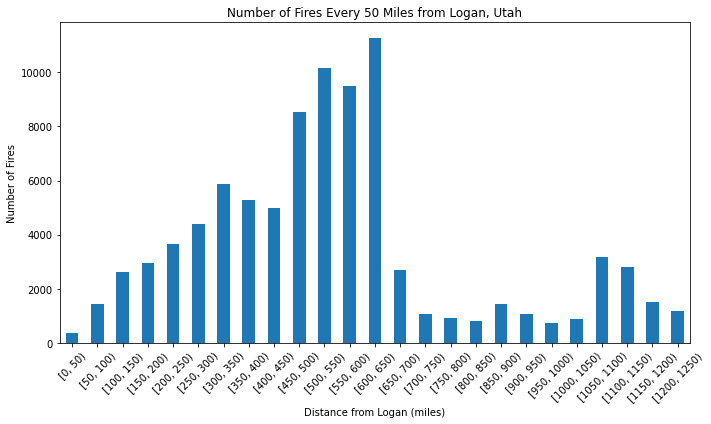

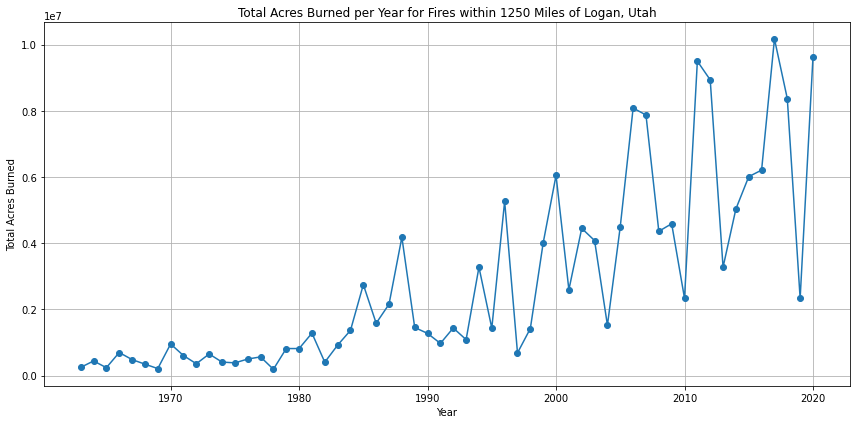

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame
# df_years = pd.read_csv('path_to_your_full_csv.csv')  # Uncomment and set the path to your CSV file

# Histogram: Number of fires occurring every 50 miles up to 1250 miles
# Assuming 'shortest_distance_to_logan' is in miles
max_distance = 1250
bin_width = 50
bins = range(0, max_distance + bin_width, bin_width)

df_years['Distance_bin'] = pd.cut(df_years['shortest_distance_to_logan'], bins=bins, right=False)
fire_count_by_distance = df_years.groupby('Distance_bin').size()

# Plot histogram
plt.figure(figsize=(10, 6))
fire_count_by_distance.plot(kind='bar')
plt.title('Number of Fires Every 50 Miles from Logan, Utah')
plt.xlabel('Distance from Logan (miles)')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time Series: Total acres burned per year within the specified distance
# Filter the data to include only fires within the max distance
df_years_within_distance = df_years[df_years['shortest_distance_to_logan'] <= max_distance]

# Group by year and sum the acres
acres_burned_per_year = df_years_within_distance.groupby('attributes_Fire_Year')['attributes_GIS_Acres'].sum()

# Plot time series graph
plt.figure(figsize=(12, 6))
acres_burned_per_year.plot(kind='line', marker='o')
plt.title('Total Acres Burned per Year for Fires within 1250 Miles of Logan, Utah')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.grid(True)
plt.tight_layout()
plt.show()


Plot 3: Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

This plot is more complicated. Below, I create yearly mean and median smoke estimates and aqi scores. I believe that these are good estimates that can give us a good idea of how wild fire rates have changed over time.

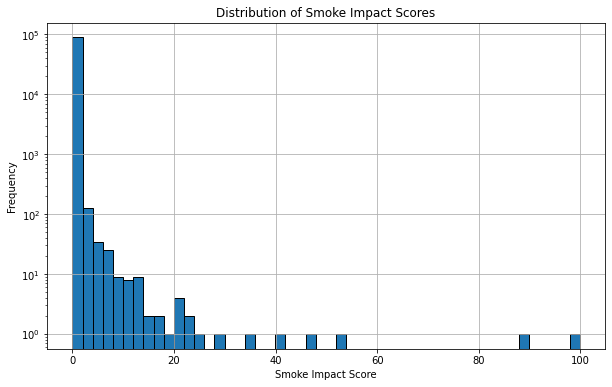

In [102]:
import matplotlib.pyplot as plt

# Plot the distribution of smoke impact scores
plt.figure(figsize=(10, 6))
plt.hist(df_years['smoke_impact'], bins=50, edgecolor='black')
plt.title('Distribution of Smoke Impact Scores')
plt.xlabel('Smoke Impact Score')
plt.ylabel('Frequency')
plt.yscale('log')  # Use a log scale for the y-axis to better visualize a wide range
plt.grid(True)
plt.show()


In [123]:
# Group by the 'attributes_Fire_Year' column and count the number of smoke estimates
smoke_estimates_per_year = df_years.groupby('attributes_Fire_Year').size()

# Print the number of smoke estimates per year
print(smoke_estimates_per_year)



attributes_Fire_Year
1963     378
1964     381
1965     331
1966     421
1967     447
1968     442
1969     343
1970     615
1971     456
1972     476
1973     507
1974     641
1975     540
1976     607
1977     541
1978     543
1979     824
1980     965
1981    1016
1982     639
1983     805
1984    1065
1985    1372
1986    1303
1987    1652
1988    1606
1989    1394
1990    1094
1991     967
1992    1070
1993     742
1994    1457
1995     977
1996    1521
1997     830
1998    1117
1999    1464
2000    2103
2001    1685
2002    1758
2003    2039
2004    1599
2005    2185
2006    3064
2007    2750
2008    2487
2009    2580
2010    2504
2011    4519
2012    3083
2013    2360
2014    2581
2015    2876
2016    3315
2017    3795
2018    3450
2019    2838
2020    4131
dtype: int64


In [124]:
# Group by 'attributes_Fire_Year' and calculate average and median smoke impact
smoke_estimate_by_year = df_years.groupby('attributes_Fire_Year')['smoke_impact'].agg(['mean', 'median']).reset_index()

# Rename the columns for clarity
smoke_estimate_by_year.columns = ['Year', 'Average_Smoke_Estimate', 'Median_Smoke_Estimate']

# Display the new DataFrame
print(smoke_estimate_by_year)


    Year  Average_Smoke_Estimate  Median_Smoke_Estimate
0   1963                0.012500               0.000117
1   1964                0.013614               0.000359
2   1965                0.006497               0.000077
3   1966                0.050899               0.000381
4   1967                0.005255               0.000070
5   1968                0.004405               0.000196
6   1969                0.009812               0.000151
7   1970                0.008262               0.000172
8   1971                0.046072               0.000279
9   1972                0.037931               0.000246
10  1973                0.021909               0.000345
11  1974                0.008871               0.000119
12  1975                0.008310               0.000117
13  1976                0.016147               0.000056
14  1977                0.006263               0.000076
15  1978                0.003849               0.000096
16  1979                0.012466               0

In [133]:
# Initialize an empty DataFrame for the yearly AQI statistics
aqi_by_year = pd.DataFrame(columns=['Year', 'Mean_AQI', 'Median_AQI'])

# Loop through each year in the aqs_data dictionary
for year, df in aqs_data.items():
    # Check if the DataFrame is not empty
    if not df.empty:
        # Calculate the mean and median AQI for the year
        mean_aqi = df['aqi'].mean()  # Replace 'aqi' with the correct column name for AQI if it's different
        median_aqi = df['aqi'].median()  # Replace 'aqi' with the correct column name for AQI if it's different
        # Append the statistics to the aqi_by_year DataFrame
        aqi_by_year = aqi_by_year.append({'Year': year, 'Mean_AQI': mean_aqi, 'Median_AQI': median_aqi}, ignore_index=True)

In [134]:
aqi_by_year

,Year,Mean_AQI,Median_AQI
0,2000.0,28.563636,25.0
1,2001.0,28.550000,28.0
2,2002.0,28.176471,27.0
3,2003.0,27.779006,27.0
4,2004.0,25.820652,24.5
5,2005.0,26.760776,25.0
6,2006.0,31.101190,30.0
7,2007.0,33.956731,31.0
8,2008.0,28.770000,27.0
9,2009.0,25.808612,25.0


Note about scaling: The effect of this scaling is to translate each feature individually such that it is in the given range on the training set, which is typically between zero and one. This has the benefit of bringing different features into a common scale while maintaining relationships in the data.

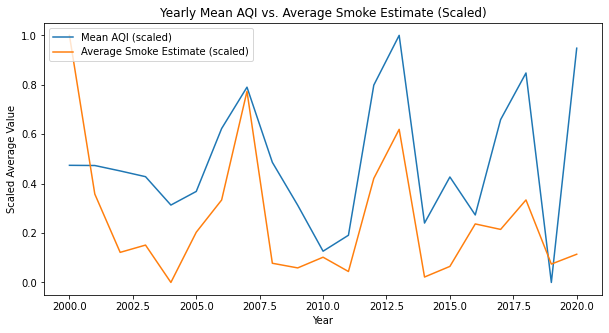

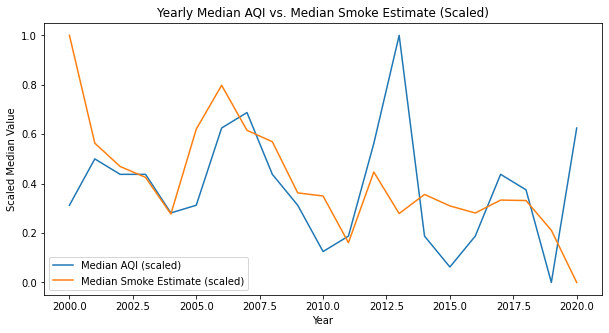

In [136]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Merge the two DataFrames on the 'Year' column
combined_data = aqi_by_year.merge(smoke_estimate_by_year, on='Year', how='inner')

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Scale the average and median values separately
combined_data[['Mean_AQI_scaled', 'Average_Smoke_Estimate_scaled']] = scaler.fit_transform(
    combined_data[['Mean_AQI', 'Average_Smoke_Estimate']]
)

combined_data[['Median_AQI_scaled', 'Median_Smoke_Estimate_scaled']] = scaler.fit_transform(
    combined_data[['Median_AQI', 'Median_Smoke_Estimate']]
)

# Plotting the scaled averages
plt.figure(figsize=(10, 5))
plt.plot(combined_data['Year'], combined_data['Mean_AQI_scaled'], label='Mean AQI (scaled)')
plt.plot(combined_data['Year'], combined_data['Average_Smoke_Estimate_scaled'], label='Average Smoke Estimate (scaled)')
plt.legend()
plt.title('Yearly Mean AQI vs. Average Smoke Estimate (Scaled)')
plt.xlabel('Year')
plt.ylabel('Scaled Average Value')
plt.show()

# Plotting the scaled medians
plt.figure(figsize=(10, 5))
plt.plot(combined_data['Year'], combined_data['Median_AQI_scaled'], label='Median AQI (scaled)')
plt.plot(combined_data['Year'], combined_data['Median_Smoke_Estimate_scaled'], label='Median Smoke Estimate (scaled)')
plt.legend()
plt.title('Yearly Median AQI vs. Median Smoke Estimate (Scaled)')
plt.xlabel('Year')
plt.ylabel('Scaled Median Value')
plt.show()
